In [6]:
# Simulation imports
from reporting import simulation
from reporting.plot_outbreak import plot_outbreak

In [7]:
# Library imports
import geopandas
import matplotlib
import shapely
import numpy as np
from matplotlib import pyplot

# Set default plot size
matplotlib.rcParams['figure.figsize'] = [16.0, 12.0]




# Day 1
## All the field reports have come in and it's time to analyse them

In [8]:
simulation.gather_reports_for_day_1()

### Let's grab the data directly from the database

In [9]:
from psycopg2 import connect
connection = connect(dbname='johnsnow')
cases = geopandas.read_postgis(
    "select * from reporting_report", connection,
    geom_col='location',
    crs={'init': 'epsg:4326'}  # The most widely used spatial reference system
)


- `cases` is a Geopandas `GeoDataFrame`
- This is just like a regular `DataFrame` except that it has to have a `GeoSeries` column containing spatial data
- we have lots of interesting new spatial methods that will act on this geometry column


In [10]:
cases[['doctor_name', 'patient_name', 'diagnosis', 'location']].sample(5)

,doctor_name,patient_name,diagnosis,location
27,Margie Roberts,Maria Sebastian,typhoid,POINT (-0.0871542618944879 51.533152287866)
43,Catherine Mcgrew,Patricia Gonzales,cholera,POINT (-0.1488995314967824 51.51770385378261)
5,Victor Haag,Christian Sensabaugh,scarletfever,POINT (-0.08859004462779974 51.53464630366966)
50,Jorge Salas,Jerry Clemons,rubella,POINT (-0.1470743345455847 51.5189254370237)
29,Flora Jones,Theo Hayes,scarletfever,POINT (-0.08679752862319255 51.53328902676814)


### Let's visualise

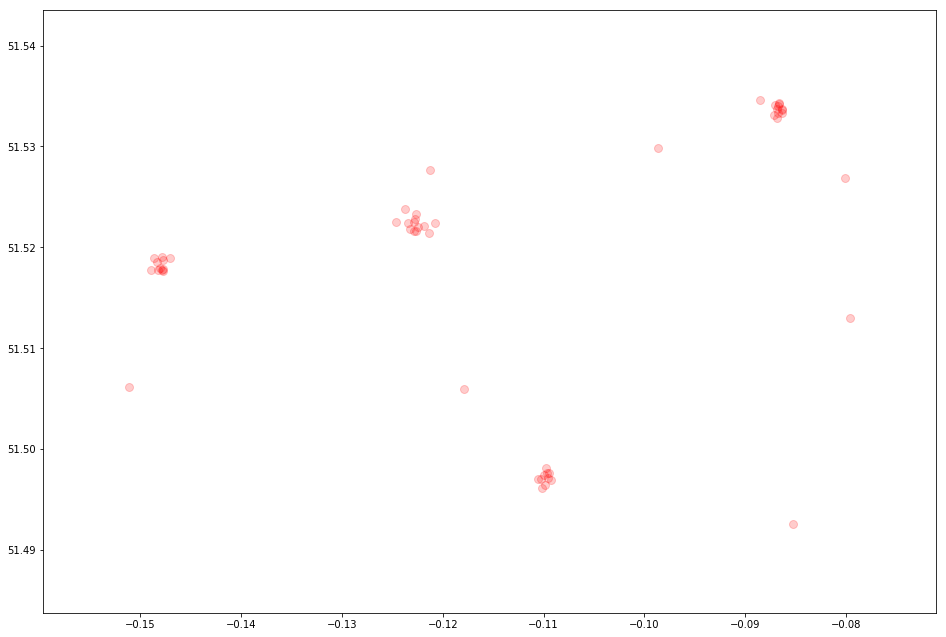

In [11]:
cases.plot(marker="o", color="red", markersize=64, alpha=0.2)

### This looks scary
- We have obvious clusters of diagnoses

### Let's distinguish different diagnoses

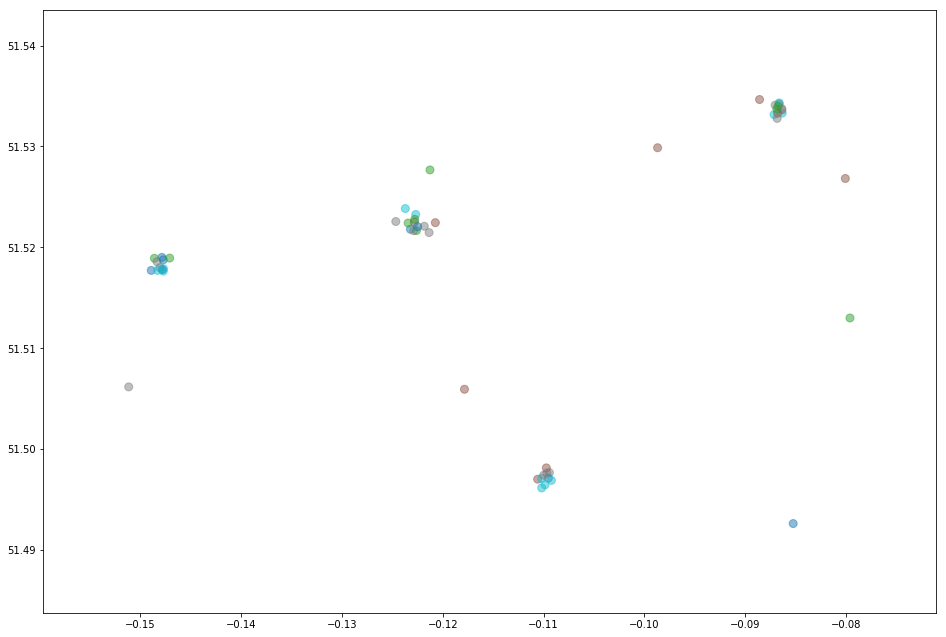

In [12]:
plot = cases.plot(marker="o", markersize=64, alpha=0.5, column='diagnosis')

### This situation doesn't look right
- Each cluster has many different diseases diagnosed within it.

### This data is useless without context. Let's map it
- We will import "Shapefiles" from the Open Street Map project
- Shapefiles are a very common format for sharing spatial data along with facts about objects
- You can say:
  - This is a road
  - It has a shape
  - It has a name: "Oxford Street"
  - It's classified as a B-Road

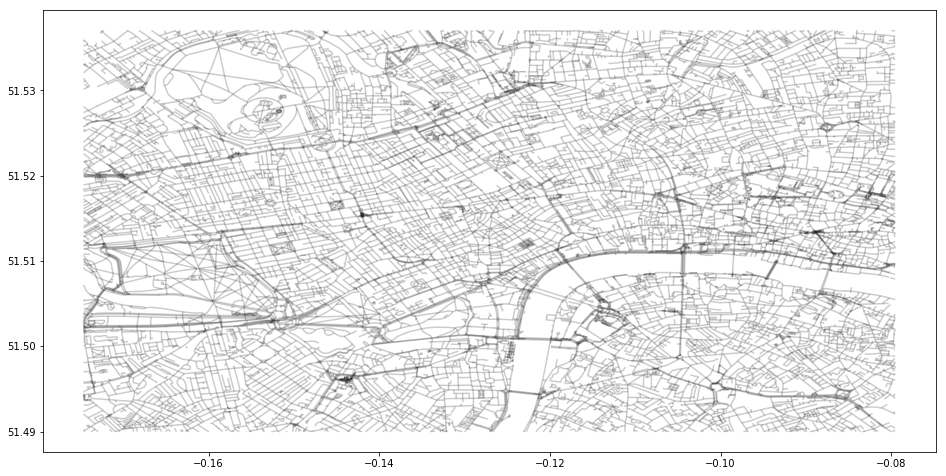

In [13]:
# Import London's roads
roads = geopandas.read_file('../open-street-map-data/london-roads_shp/')
roads.plot(color="black", alpha=0.2)

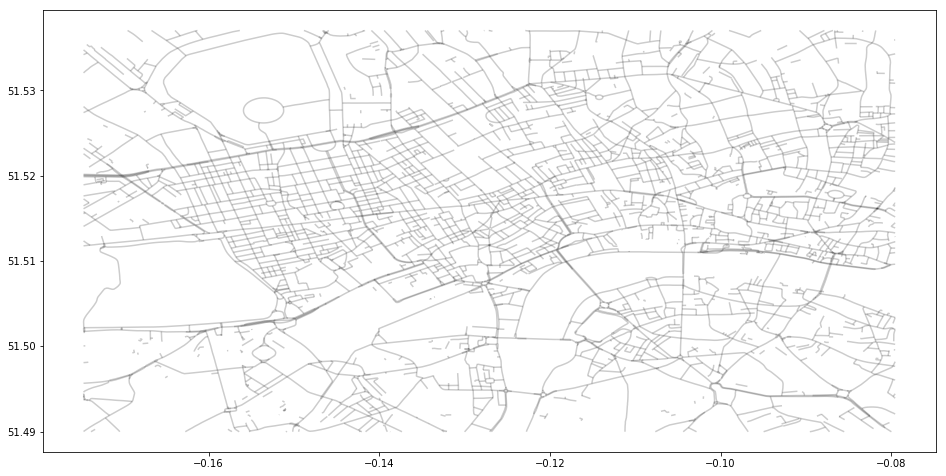

In [14]:
# Filter roads by type
mains = roads[roads['highway'].isin(('trunk', 'primary', 'secondary', 'tertiary', 'unclassified'))]
mains.plot(color="black", alpha=0.2)

In [15]:
# Import London's rivers
rivers = geopandas.read_file('../open-street-map-data/london-rivers_shp/')

Let's use that extra data to filter the shapes we've imported:

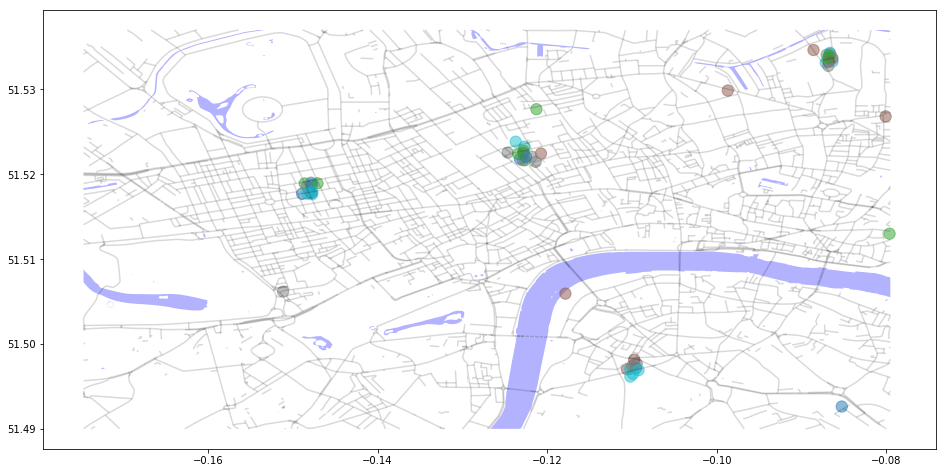

In [16]:
# Draw all three datasets on one axis to make a map
figure, axes = pyplot.subplots()

rivers.plot(ax=axes, color='blue', alpha=0.3)
mains.plot(ax=axes, color="black", alpha=0.15)
cases.plot(ax=axes, marker="o", column="diagnosis", markersize=128, alpha=0.5)

pyplot.show()

### What's going on? I have a hunch...

In [17]:
# Let's get open street map data about medical facilities
medical = geopandas.read_file('../open-street-map-data/london-hospitals_shp/')

# And use pandas filtering to select only the hospitals
hospitals = medical[medical['amenity'] == 'hospital'].copy()

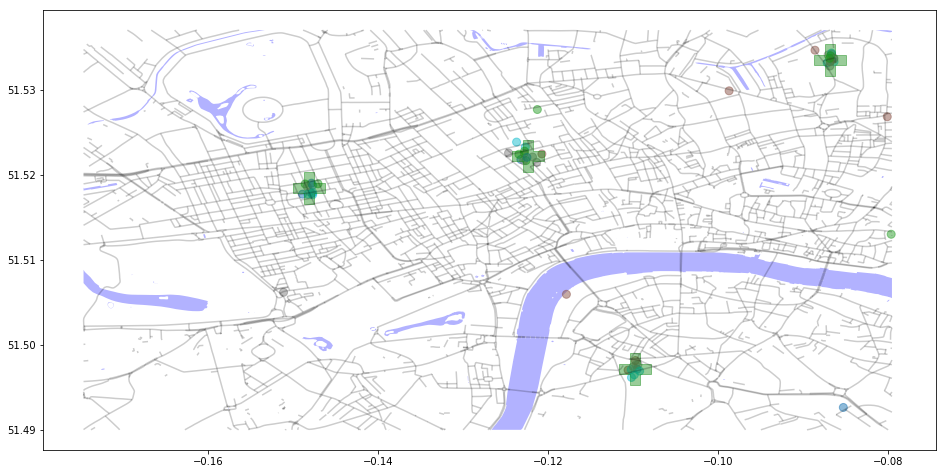

In [18]:
# Overlay our various geo-datasets
figure, axes = pyplot.subplots()
rivers_plot = rivers.plot(ax=axes, color='blue', alpha=0.3)
map_plot = mains.plot(ax=axes, color="black", alpha=0.2)
cases_plot = cases.plot(ax=axes, marker="o", column="diagnosis", markersize=64, alpha=0.5)

# Plot a green cross at the location of each hospital
final = hospitals.plot(ax=axes, marker="P", markersize=1000, color="green", alpha=0.4)

pyplot.show()

### We need to improve our analysis

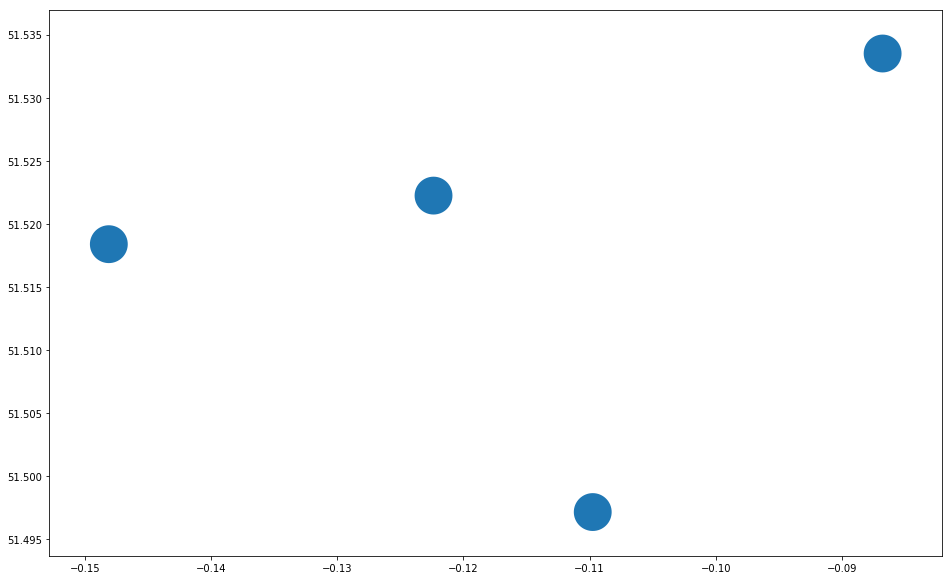

In [19]:
# Create a polygon representing about 150m around each hospital
hospitals['geometry'] = hospitals['geometry'].buffer(0.0015)
hospitals.plot()

![Joins](spatial-join.png)

In [21]:
# Join together the hospital zones with the cases
# The "join" is a spatial one - we are joining cases with the hospitals that they are close to
joined_cases = geopandas.sjoin(
    left_df=cases,
    right_df=hospitals,
    how='left',
    op='within',
)

In [22]:
# Now each case that happened in a hospital is associated with the relevant hospital
joined_cases[['doctor_name', 'patient_name', 'diagnosis', 'name']].sample(10)

,doctor_name,patient_name,diagnosis,name
29,Flora Jones,Theo Hayes,scarletfever,The Hoxton Surgery
6,Anita Davis,Bertha Sandmeier,smallpox,NaN
1,Susan Hoffman,Rebecca Quandt,smallpox,NaN
3,Leslie Dunbar,Edward Lindsey,scarletfever,NaN
35,Michelle Rondeau,Gladys Mercado,scarletfever,Cambian Churchill
44,Paul Jeter,Michael Osorio,cholera,Wimpole Dental
41,Tanner Keefer,Carl Hodnett,typhoid,Cambian Churchill
34,Richard Peterson,Henrietta Lambert,typhoid,Cambian Churchill
37,Andrea Bailey,Rosaria Finn,smallpox,Cambian Churchill
42,Christopher Selman,David Brown,typhoid,Wimpole Dental


### Let's find cases that didn't happen at hospitals

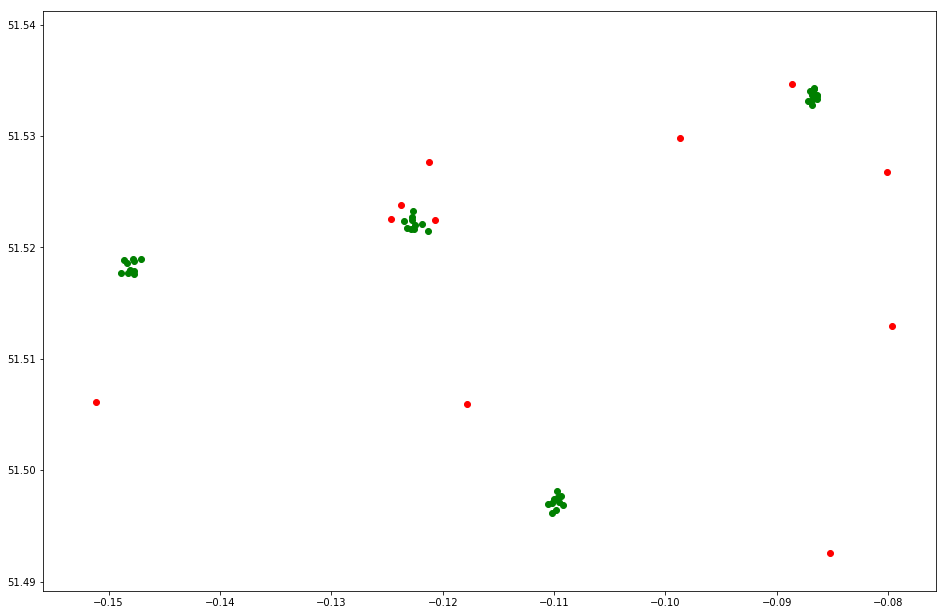

In [23]:
hospital_cases = joined_cases[~joined_cases['name'].isnull()]
non_hospital_cases = joined_cases[joined_cases['name'].isnull()]

axes = hospital_cases.plot(color="green")
non_hospital_cases.plot(ax=axes, color="red")


### And let's pull everything together

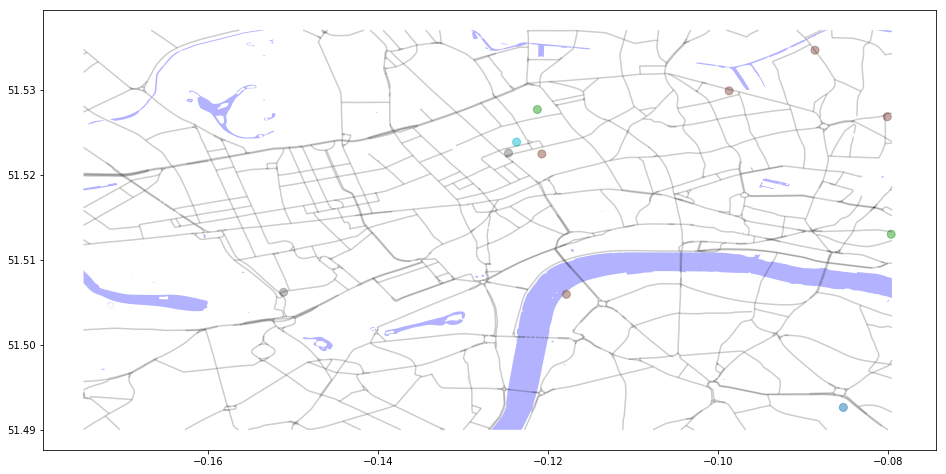

In [24]:
plot_outbreak()

# Day 2
### Not so peaceful

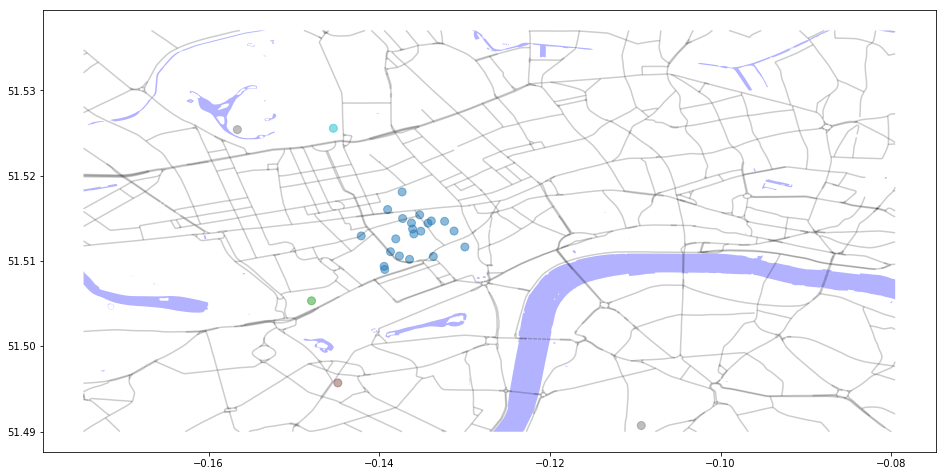

In [25]:
simulation.gather_reports_for_day_2()
plot_outbreak()

### If I was John Snow, I would investigate...

# Day 3

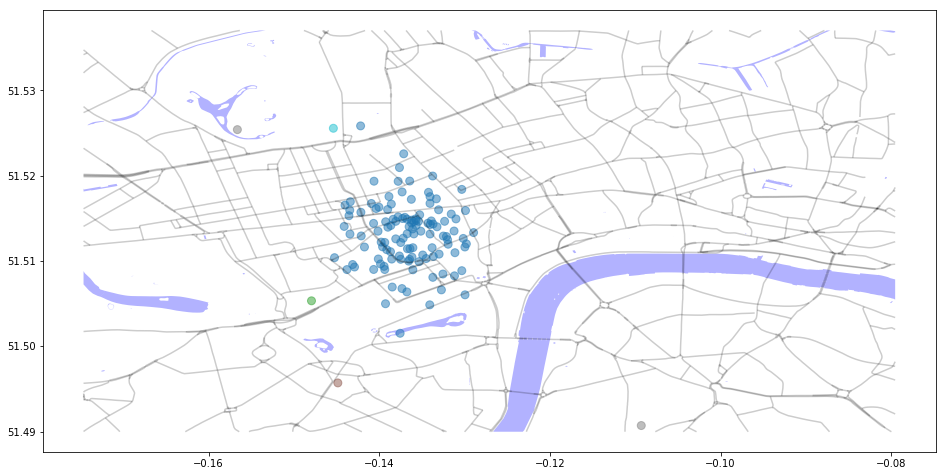

In [26]:
simulation.gather_reports_for_day_3()
plot_outbreak()

# 28 days later

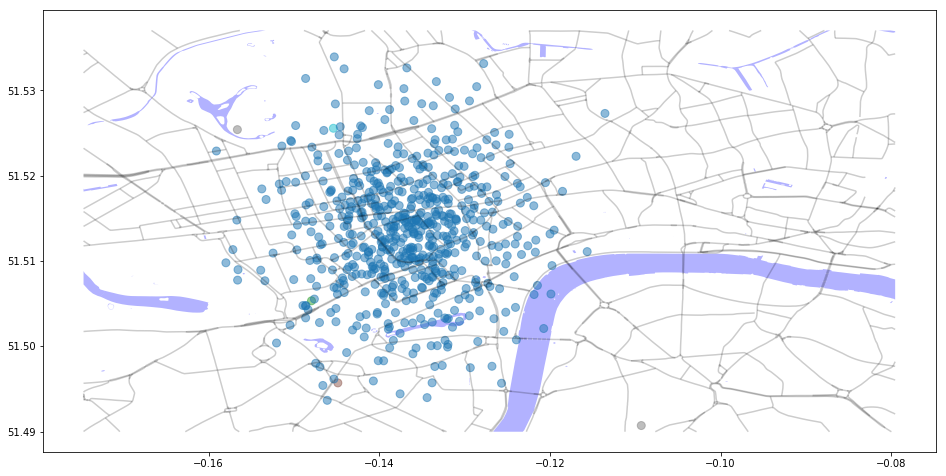

In [27]:
simulation.gather_reports_for_day_28()
plot_outbreak()